In [2]:
import pandas as pd

enrol = pd.read_csv("../data/processed/enrolment_aggregated.csv", parse_dates=['date'])
demo  = pd.read_csv("../data/processed/demographic_updates_aggregated.csv", parse_dates=['date'])
bio   = pd.read_csv("../data/processed/biometric_updates_aggregated.csv")

print(enrol.shape, demo.shape, bio.shape)


(66749, 6) (86125, 5) (79794, 5)


In [3]:
# Merge all three datasets on date, state, district
merged = (
    enrol
    .merge(demo, on=['date', 'state', 'district'], how='left')
    .merge(bio,  on=['date', 'state', 'district'], how='left')
)

# Replace NaNs from left joins with 0
merged.fillna(0, inplace=True)

print(merged.shape)
merged.head()


(66749, 10)


,date,state,district,age_0_5,age_5_17,age_18_greater,demo_age_5_17,demo_age_17_plus,bio_age_5_17,bio_age_17_plus
0,01-04-2025,Assam,Baksa,408,483,187,0.0,0.0,2598.0,474.0
1,01-04-2025,Assam,Barpeta,138,54,23,0.0,0.0,9902.0,2067.0
2,01-04-2025,Assam,Biswanath,104,114,32,0.0,0.0,1463.0,323.0
3,01-04-2025,Assam,Bongaigaon,221,87,61,348.0,4007.0,4512.0,1135.0
4,01-04-2025,Assam,Cachar,988,461,299,0.0,0.0,9483.0,2866.0


In [4]:
# Total updates
merged['total_updates'] = (
    merged['demo_age_5_17'] +
    merged['demo_age_17_plus'] +
    merged['bio_age_5_17'] +
    merged['bio_age_17_plus']
)

# Total new enrolments
merged['total_enrolments'] = (
    merged['age_0_5'] +
    merged['age_5_17'] +
    merged['age_18_greater']
)

# Update Stress Index
merged['USI'] = merged['total_updates'] / merged['total_enrolments']


In [5]:
merged[['state', 'district', 'USI']] \
    .sort_values('USI', ascending=False) \
    .head(10)


,state,district,USI
7416,Maharashtra,Nashik,11082.0
7406,Maharashtra,Ahmadnagar,10615.0
7418,Maharashtra,Parbhani,5316.0
7414,Maharashtra,Nanded,5259.0
7508,Tamil Nadu,Tiruvallur,4841.0
7411,Maharashtra,Latur,4747.0
7422,Maharashtra,Solapur,4303.0
7502,Tamil Nadu,Kancheepuram,4278.0
7518,Telangana,Mahabubnagar,3945.0
7410,Maharashtra,Jalna,3887.0


In [6]:
merged['CLCS'] = merged['bio_age_5_17'] / merged['age_5_17']

# Cap extreme values (safe governance practice)
merged['CLCS'] = merged['CLCS'].clip(lower=0, upper=1)


In [7]:
merged[['state', 'district', 'CLCS']] \
    .sort_values('CLCS') \
    .head(10)


,state,district,CLCS
66738,West Bengal,Paschim Medinipur,0.0
66710,Uttarakhand,Uttarkashi,0.0
66709,Uttarakhand,Udham Singh Nagar,0.0
66708,Uttarakhand,Tehri Garhwal,0.0
66707,Uttarakhand,Rudraprayag,0.0
66706,Uttarakhand,Pithoragarh,0.0
66705,Uttarakhand,Pauri Garhwal,0.0
66704,Uttarakhand,Nainital,0.0
66703,Uttarakhand,Haridwar,0.0
66701,Uttarakhand,Dehradun,0.0


In [8]:
merged['EQS'] = 1 - (merged['bio_age_17_plus'] / merged['age_18_greater'])

merged['EQS'] = merged['EQS'].clip(lower=0, upper=1)


In [9]:
merged[['state', 'district', 'EQS']] \
    .sort_values('EQS') \
    .head(10)


,state,district,EQS
19,Assam,Karimganj,0.0
46,Bihar,West Champaran,0.0
45,Bihar,Vaishali,0.0
44,Bihar,Sitamarhi,0.0
43,Bihar,Saran,0.0
42,Bihar,Purnia,0.0
41,Bihar,Patna,0.0
40,Bihar,Muzaffarpur,0.0
39,Bihar,Munger,0.0
38,Bihar,Madhubani,0.0


<Axes: title={'center': 'Aadhaar Pulse – Temporal Signals (Baksa)'}, xlabel='date'>

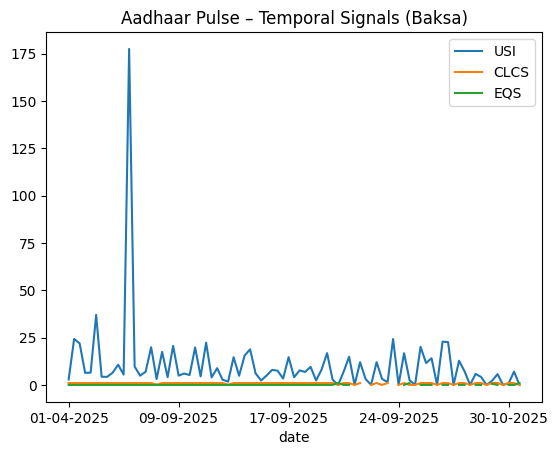

In [10]:
example_district = merged['district'].iloc[0]

merged[merged['district'] == example_district] \
    .set_index('date')[['USI', 'CLCS', 'EQS']] \
    .plot(title=f"Aadhaar Pulse – Temporal Signals ({example_district})")
